In [13]:
import pandas as pd
import spotipy
import spotipy.util as util
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from tqdm import tqdm_notebook
from google.cloud import language_v1
from google.cloud.language_v1 import enums
import six
import os
from scipy import optimize

In [14]:
key_file = 'assets/keys.json'
keys = json.load(open(key_file))

SPOTIPY_CLIENT_ID= keys["client_id"]
SPOTIPY_CLIENT_SECRET= keys["client_secret"]
SPOTIPY_REDIRECT_URI= keys["redirect_url"]

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/carlosortega/Documents/GitHub/SUSA-Research-MusicMoods/assets/google_keys.json"

In [15]:
token = util.prompt_for_user_token("1274418332", 
                                   scope = "user-library-read", 
                                   client_id=SPOTIPY_CLIENT_ID, 
                                   client_secret=SPOTIPY_CLIENT_SECRET, 
                                   redirect_uri = SPOTIPY_REDIRECT_URI)
spotify = spotipy.Spotify(auth=token)

In [16]:
billboard = pd.read_csv("data/billboard_lyrics_1964-2015.csv")
billboard['Query'] = 'artist: ' + billboard['Artist'] + ', track: ' + billboard['Song']
billboard.drop(columns=['Query'], inplace=True)
billboard.head()

,Rank,Song,Artist,Year,Lyrics,Source
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0


In [17]:
valences = []
durations = []
for index, row in tqdm_notebook(billboard.iterrows()):
    try:
        curr_song = spotify.search(row['Query'])['tracks']['items'][0]['id']
        valence = spotify.audio_features(curr_song)[0]['valence']
        duration = spotify.audio_features(curr_song)[0]['duration_ms']
        durations.append(duration)
        valences.append(float(valence))
    except:
        valences.append(np.nan)
        durations.append(np.nan)

billboard['Valence'] = valences
billboard['Duration_ms'] = durations

In [18]:
billboard.to_csv("data/billboard_with_data.csv", index=False)
billboard.head()

,Rank,Song,Artist,Year,Lyrics,Source,Valence,Duration_ms
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0,NaN,NaN
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0,NaN,NaN
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0,NaN,NaN
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0,NaN,NaN
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0,NaN,NaN


In [19]:
billboard_updated = pd.read_csv("data/billboard_with_data.csv")
billboard_updated['Lyrics'].replace('  ', np.nan, inplace=True)
billboard_updated.dropna(axis=0,inplace=True)
billboard_updated.head()

,Rank,Song,Artist,Year,Lyrics,Source,Valence,Duration_ms


In [29]:
def authenticate():
    from google.cloud import storage

    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())

authenticate()

In [30]:
lyrics = []
for index, row in tqdm_notebook(billboard_updated.iterrows()):
    lyric = row['Lyrics']
    if isinstance(lyric, six.binary_type):
        lyric = lyric.decode('utf-8')
    lyrics.append(lyric)

In [22]:
client = language_v1.LanguageServiceClient()

type_ = enums.Document.Type.PLAIN_TEXT

sentiments = []
for i in tqdm_notebook(range(len(lyrics))):
    document = {'type': type_, 'content': lyrics[i]}
    
    try:
        response = client.analyze_sentiment(document)
    except:
        sentiments.append(np.nan)
        continue
    
    sentiment = response.document_sentiment
    
    sentiments.append(sentiment.score)

billboard_updated['Sentiment'] = sentiments
billboard_updated.dropna(axis=0,inplace=True)
billboard_updated.to_csv("data/billboard_with_data.csv", index=False)

In [23]:
billboard_updated = pd.read_csv("data/billboard_with_data.csv")
billboard_updated.head()

,Rank,Song,Artist,Year,Lyrics,Source,Valence,Duration_ms,Sentiment


In [24]:
#New Table with Only Necessary Info
stats = billboard_updated[['Year', 'Valence', 'Sentiment', 'Duration_ms']]
stats['Word Count'] = billboard_updated['Lyrics'].apply(len) 
stats['Lyrical Density'] = stats['Word Count'] / stats['Duration_ms'] * 1000
stats.head()

,Year,Valence,Sentiment,Duration_ms,Word Count,Lyrical Density


In [25]:
gloom_index = ((1 - stats['Valence']) + (stats['Sentiment'] * (1 + stats['Lyrical Density']))) / 2
stats['Gloom Index'] = gloom_index
stats['Normalized Gloom Index'] = (gloom_index - min(gloom_index)) / (max(gloom_index) - min(gloom_index))
stats.head()

ValueError: min() arg is an empty sequence

In [26]:
gloom_by_year = stats[['Year', 'Normalized Gloom Index']]
plt.plot(gloom_by_year['Year'], gloom_by_year['Normalized Gloom Index'], ',')
plt.show()

KeyError: "['Normalized Gloom Index'] not in index"

In [27]:
means = gloom_by_year.groupby(by="Year").mean().reset_index()
means.plot("Year", "Normalized Gloom Index")
plt.show()

NameError: name 'gloom_by_year' is not defined

In [28]:
n60 = list(stats[stats['Year'] < 1970]['Normalized Gloom Index'])
n70 = list(stats[(stats['Year'] >= 1970) & (stats['Year'] < 1980)]['Normalized Gloom Index'])
n80 = list(stats[(stats['Year'] >= 1980) & (stats['Year'] < 1990)]['Normalized Gloom Index'])
n90 = list(stats[(stats['Year'] >= 1990) & (stats['Year'] < 2000)]['Normalized Gloom Index'])
n20 = list(stats[(stats['Year'] >= 2000) & (stats['Year'] < 2010)]['Normalized Gloom Index'])
n2_1 = list(stats[(stats['Year'] >= 2010)]['Normalized Gloom Index'])

labels = ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

plt.boxplot([n60, n70, n80, n90, n20, n2_1], showfliers=False, labels=labels)
plt.show()

KeyError: 'Normalized Gloom Index'

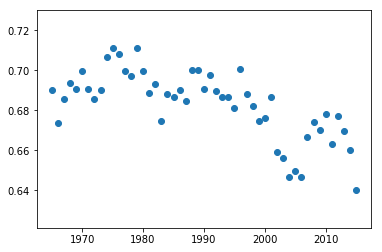

In [17]:
plt.scatter(means['Year'], means['Normalized Gloom Index'])
plt.show()

In [18]:
years = means["Year"]
gloom_index = means['Normalized Gloom Index']
z = np.polyfit(x=years, y=gloom_index, deg=3)
p = np.poly1d(z)
xp = range(1965, 2016)

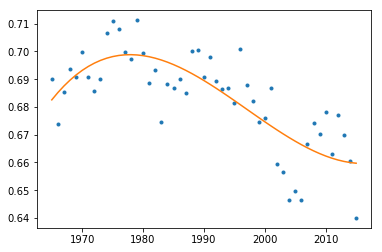

In [19]:
_ = plt.plot(years, gloom_index, '.', xp, p(xp), '-')
plt.show()

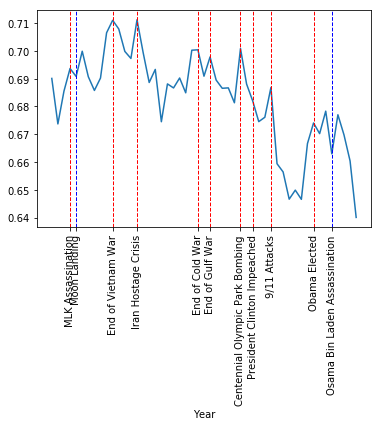

In [123]:
means = gloom_by_year.groupby(by="Year").mean().reset_index()
means.plot("Year", "Normalized Gloom Index", legend=False)

#MLK Assassination
plt.axvline(x=1968, color='r', linewidth=1, linestyle='--')

#Moon Landing
plt.axvline(x=1969, color='b', linewidth=1, linestyle='--')

#End of Vietnam War
plt.axvline(x=1975, color='r', linewidth=1, linestyle='--')

#Iran Hostage Crisis
plt.axvline(x=1979, color='r', linewidth=1, linestyle='--')

#End of Cold War and the Fall of the Berlin Wall
plt.axvline(x=1989, color='r', linewidth=1, linestyle='--')

#End of Gulf War
plt.axvline(x=1991, color='r', linewidth=1, linestyle='--')

#Centennial Olympic Park Bombing
plt.axvline(x=1996, color='r', linewidth=1, linestyle='--')

#President Clinton Impeachment
plt.axvline(x=1998, color='r', linewidth=1, linestyle='--')

#9/11 Attacks
plt.axvline(x=2001, color='r', linewidth=1, linestyle='--')

#Obama Election Assassination
plt.axvline(x=2008, color='r', linewidth=1, linestyle='--')

#Osama Bin Laden 
plt.axvline(x=2011, color='b', linewidth=1, linestyle='--')

plt.xticks([1968, 1969, 1975, 1979, 1989, 1991, 1996, 1998, 2001, 2008, 2011], ('MLK Assassination' , 'Moon Landing',
                                                        'End of Vietnam War',
                                                        'Iran Hostage Crisis', 'End of Cold War', 'End of Gulf War', 
                                                        'Centennial Olympic Park Bombing', 'President Clinton Impeached',
                                                        '9/11 Attacks', 'Obama Elected', 'Osama Bin Laden Assassination')
           , rotation=90 )



plt.show()

In [10]:
pd.read_csv("data/billboard_with_data.csv")

,Rank,Song,Artist,Year,Lyrics,Source,Valence,Duration_ms
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0,NaN,NaN
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0,NaN,NaN
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0,NaN,NaN
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0,NaN,NaN
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0,NaN,NaN
5,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,1.0,NaN,NaN
6,7,help,the beatles,1965,help i need somebody help not just anybody hel...,3.0,NaN,NaN
7,8,cant you hear my heart beat,hermans hermits,1965,carterlewis every time i see you lookin my way...,5.0,NaN,NaN
8,9,crying in the chapel,elvis presley,1965,you saw me crying in the chapel the tears i s...,1.0,NaN,NaN
9,10,my girl,the temptations,1965,ive got sunshine on a cloudy day when its cold...,3.0,NaN,NaN
